In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings

warnings.filterwarnings("ignore")

In [2]:
tf.keras.backend.set_floatx("float64")
h = 3

class DNModel(tf.keras.Model):
    def __init__(self, N):
        super().__init__()
        
        
        self.N = N
        self.iteration = 0
        
        self.dense1 = tf.keras.layers.Dense(64)
        self.dense2 = tf.keras.layers.Dense(64)
        self.out = tf.keras.layers.Dense(1)
        
        self.w = tf.keras.layers.Dense(h)
        self.hidden_initial = tf.Variable(tf.random.normal((1,h), mean=0.0, stddev=1.0, dtype=tf.dtypes.float64))
        self.hidden = tf.repeat(self.hidden_initial, N, axis=0)
        
    def call(self, x):
        x = tf.concat((self.hidden, x), axis=1)  
        x = tf.nn.tanh(self.dense1(x))
        x = tf.nn.tanh(self.dense2(x))

        return tf.math.exp(self.out(x))

    def rnn_forward(self, x):
        self.iteration += 1
        x = tf.concat((self.hidden, x), axis=1)
        self.hidden = tf.tanh(self.w(x))
    
    def hidden_reset(self):
        self.hidden = tf.repeat(self.hidden_initial, N, axis=0)
        self.iteration = 0
        
    
    
    
@tf.function
def loss(model, x1, x2):
    
    with tf.GradientTape() as g:
        g.watch(x1)
        with tf.GradientTape() as gg:
            gg.watch(x1)
            
            model.hidden_reset()
            psi = model.call(x1)
            
            model.rnn_forward(x1)
            psi *= model.call(x2)

        d_psi = gg.gradient(psi, x1)
    d2_psi1 = g.gradient(d_psi, x1)
    
    with tf.GradientTape() as g:
        g.watch(x2)
        with tf.GradientTape() as gg:
            gg.watch(x2)
            
            model.hidden_reset()
            psi = model.call(x1)
            
            model.rnn_forward(x1)
            psi *= model.call(x2)

        d_psi = gg.gradient(psi, x2)
    d2_psi2 = g.gradient(d_psi, x2)
    
    lap = d2_psi1 + d2_psi2
    
    model.hidden_reset()
    psi = model.call(x1)
            
    model.rnn_forward(x1)
    psi *= model.call(x2)
    
    E_L = -0.5/psi*lap + 0.5*(x1**2 + x2**2) + 1/tf.math.sqrt((x1-x2)**2 + 0.01**2)
    
    E_L = tf.stop_gradient(E_L)
    E = tf.math.reduce_mean(E_L)
    
    
    psi_detach = tf.stop_gradient(psi)
    return E, 2*(tf.math.reduce_mean(psi/psi_detach*E_L) - tf.math.reduce_mean(psi/psi_detach)*E)


@tf.function
def grad(model, x1, x2):
    with tf.GradientTape() as tape:
        E, loss_value = loss(model, x1, x2)

    return E, tape.gradient(loss_value, model.trainable_variables)



def sample(model, N, n):
    total = 0
    x_old = tf.random.uniform((N,1), minval=-2, maxval=2, dtype=tf.dtypes.float64)
    psi_old = model(x_old).numpy()
    
    for i in range(n):
        x_new = x_old + tf.random.uniform((N,1), minval=-1, maxval=1, dtype=tf.dtypes.float64)
        psi_new = model(x_new).numpy()
      
    
        U = np.random.uniform(0, 1, (N,1))
        mask = ((psi_new/psi_old)**2 > U) #vectorized acceptance criterion
        x_old = x_old.numpy()
        x_new = x_new.numpy()
        
        x_old[mask]   = x_new[mask]  #move walkers
        psi_old[mask] = psi_new[mask]
        x_old = tf.convert_to_tensor(x_old, dtype=tf.dtypes.float64)
        total += np.sum(mask)
    
    return x_old, total

In [3]:
N = 5000

energy = []

tf.random.set_seed(42)
np.random.seed(42)
model = DNModel(N)
optimizer = tf.keras.optimizers.Adam(epsilon=1e-08)

In [4]:
num_epochs = 4000
n = 20
for epoch in tqdm(range(num_epochs)):
    
    model.hidden_reset()
    x1 = sample(model, N, n)[0]
    model.rnn_forward(x1)
    x2 = sample(model, N, n)[0]

    E, gradients = grad(model, x1, x2)
    energy.append(E)
    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    
    if epoch%100 == 0: 
        print(f"epoch: {epoch}, Energy: {E}")

epoch: 0, Energy: 10.077510993295084
epoch: 100, Energy: 4.142055607454796
epoch: 200, Energy: 3.5476583935233736
epoch: 300, Energy: 3.2565345496230758
epoch: 400, Energy: 2.6613477014785043
epoch: 500, Energy: 2.7419148045277093
epoch: 600, Energy: 2.776900872882466
epoch: 700, Energy: 2.7988495650559115
epoch: 800, Energy: 2.7008295514626175
epoch: 900, Energy: 2.7368169756088863
epoch: 1000, Energy: 2.7716011038792523
epoch: 1100, Energy: 2.7501217080537543
epoch: 1200, Energy: 2.713566791342498
epoch: 1300, Energy: 2.6641359128191486
epoch: 1400, Energy: 2.6402481522875454



KeyboardInterrupt: 

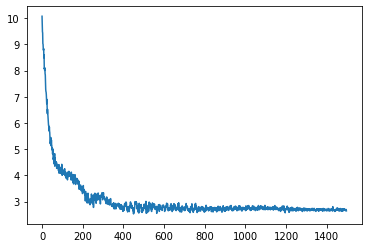

In [5]:
plt.plot(energy)
plt.show()

In [6]:
def f(x):
    x_lin = np.linspace(-4, 4, N)
    dx = x_lin[1] - x_lin[0]
    tf_x_lin = tf.convert_to_tensor(x_lin.reshape(-1,1), dtype=tf.dtypes.float64)

    x1 = tf.convert_to_tensor(x*np.ones((N,1)), dtype=tf.dtypes.float64)

    model.hidden_reset()
    psi1 = model(tf_x_lin).numpy()[:, 0]
    
    model.rnn_forward(x1)
    psi2 = model(tf_x_lin).numpy()[:, 0]
    
    psi3 = np.exp(-0.5*x_lin**2)

    plt.plot(x_lin, 1/dx*psi1**2/np.sum(psi1**2))
    plt.plot(x_lin, 1/dx*psi2**2/np.sum(psi2**2))
    plt.plot(x_lin, 1/dx*psi3**2/np.sum(psi3**2), "--")
    
    plt.plot(x, 0.01, "bo")
    plt.ylim(0, 0.8)
    plt.show()

interact(f, x=(-4.0, 4., 0.1))

interactive(children=(FloatSlider(value=0.0, description='x', max=4.0, min=-4.0), Output()), _dom_classes=('wi…

<function __main__.f(x)>

#### Estimate energy

In [7]:
N = 1000000
model.hidden_reset()
x1 = sample(model, N, 20)[0]
model.rnn_forward(x1)
x2 = sample(model, N, 20)[0]

with tf.GradientTape() as g:
    g.watch(x1)
    with tf.GradientTape() as gg:
        gg.watch(x1)

        model.hidden_reset()
        psi = model.call(x1)

        model.rnn_forward(x1)
        psi *= model.call(x2)

    d_psi = gg.gradient(psi, x1)
d2_psi1 = g.gradient(d_psi, x1)

with tf.GradientTape() as g:
    g.watch(x2)
    with tf.GradientTape() as gg:
        gg.watch(x2)

        model.hidden_reset()
        psi = model.call(x1)

        model.rnn_forward(x1)
        psi *= model.call(x2)

    d_psi = gg.gradient(psi, x2)
d2_psi2 = g.gradient(d_psi, x2)

lap = d2_psi1 + d2_psi2

model.hidden_reset()
psi = model.call(x1)

model.rnn_forward(x1)
psi *= model.call(x2)

E_L = -0.5/psi*lap + 0.5*(x1**2 + x2**2) + 1/tf.math.sqrt((x1-x2)**2 + 0.1**2)

E_L = tf.stop_gradient(E_L)
E = tf.math.reduce_mean(E_L)

print(E)
x = tf.concat((x1, x2), axis=0).numpy()

tf.Tensor(2.5756125808816033, shape=(), dtype=float64)


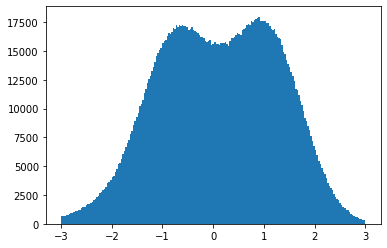

In [8]:
bins = np.linspace(-3, 3, 200)

plt.hist(x, bins=bins)
plt.show()